### Dataset Aggregation and Summary

This script collects all previously recorded gesture CSV files and merges them into a single dataset.

Processing steps:

1. Searches the `../data/raw` directory for all `.csv` files  
2. Loads each file into a separate pandas DataFrame  
3. Concatenates them into one unified DataFrame (`combined_df`)  
   - All gesture samples from different recording sessions are combined
   - Indexes are reset to ensure consistency

After merging, the dataset can be analyzed, including:

- number of samples per gesture label  
- distribution of left vs. right hand samples  

This combined dataset will later be used for model training and evaluation.


In [ ]:
import pandas as pd
import os
from glob import glob

In [ ]:
# all raw files 
raw_data_path = "../data/raw"

csv_files = glob(os.path.join(raw_data_path, "*.csv"))

if not csv_files:
    print(" No CVS file was found(((")
else:
    print(f" {len(csv_files)} files were found")

    dataframes = []
    for file in csv_files:
        df = pd.read_csv(file)
        dataframes.append(df)

    combined_df = pd.concat(dataframes, ignore_index=True)

# Save dataset as new file

In [ ]:
# new file
output_file = "../data/processed/data.csv"
combined_df.to_csv(output_file, index=False)
print(f"Final file was saved to {output_file}. Size: {combined_df.shape}")

## Quick integrity checks
Verifies file can be read, shows first rows, checks for missing columns or NaNs

In [ ]:
# Quick info
print("Rows:", len(combined_df))
print("Columns:", combined_df.columns.tolist())
display(combined_df.head())

# Basic checks
missing_per_col = combined_df.isna().sum()
print("\nMissing values per column:")
display(missing_per_col[missing_per_col > 0])

# Ensure expected columns (21 landmarks * 3 + 2)
expected_cols = [f"{axis}{i}" for i in range(21) for axis in ("x","y","z")] + ["gesture","is_right_hand"]
missing_expected = [c for c in expected_cols if c not in df.columns]
if missing_expected:
    print("WARNING: missing expected columns:", missing_expected)
else:
    print("All expected columns present.")

# High-level summary: counts, unique gestures, class balance
- table showing left/right counts per gesture
- color gradient highlights imbalance

In [ ]:
pivot = combined_df.pivot_table(index="gesture", columns="is_right_hand", 
                       values="x0", aggfunc="count", fill_value=0)
pivot.columns = ["left_count", "right_count"]
pivot["total"] = pivot.sum(axis=1)
pivot = pivot.sort_values("total", ascending=False)
display(pivot.style.background_gradient(cmap="Blues").format("{:.0f}"))


# Descriptive statistics per coordinate (aggregate)

Checks distribution and scale of normalized coordinates. Look for unexpected out-of-range values.

In [ ]:
landmark_cols = [c for c in combined_df.columns if c not in ("gesture","is_right_hand")]
desc = combined_df[landmark_cols].describe().T  # mean, std, min, max, etc.
desc = desc[["count","mean","std","min","25%","50%","75%","max"]]
display(desc.style.format({
    "mean": "{:.3f}", "std": "{:.3f}", "min":"{:.3f}", "25%":"{:.3f}", "50%":"{:.3f}", "75%":"{:.3f}", "max":"{:.3f}"
}))


# Landmark-wise dispersion per gesture (boxplots)


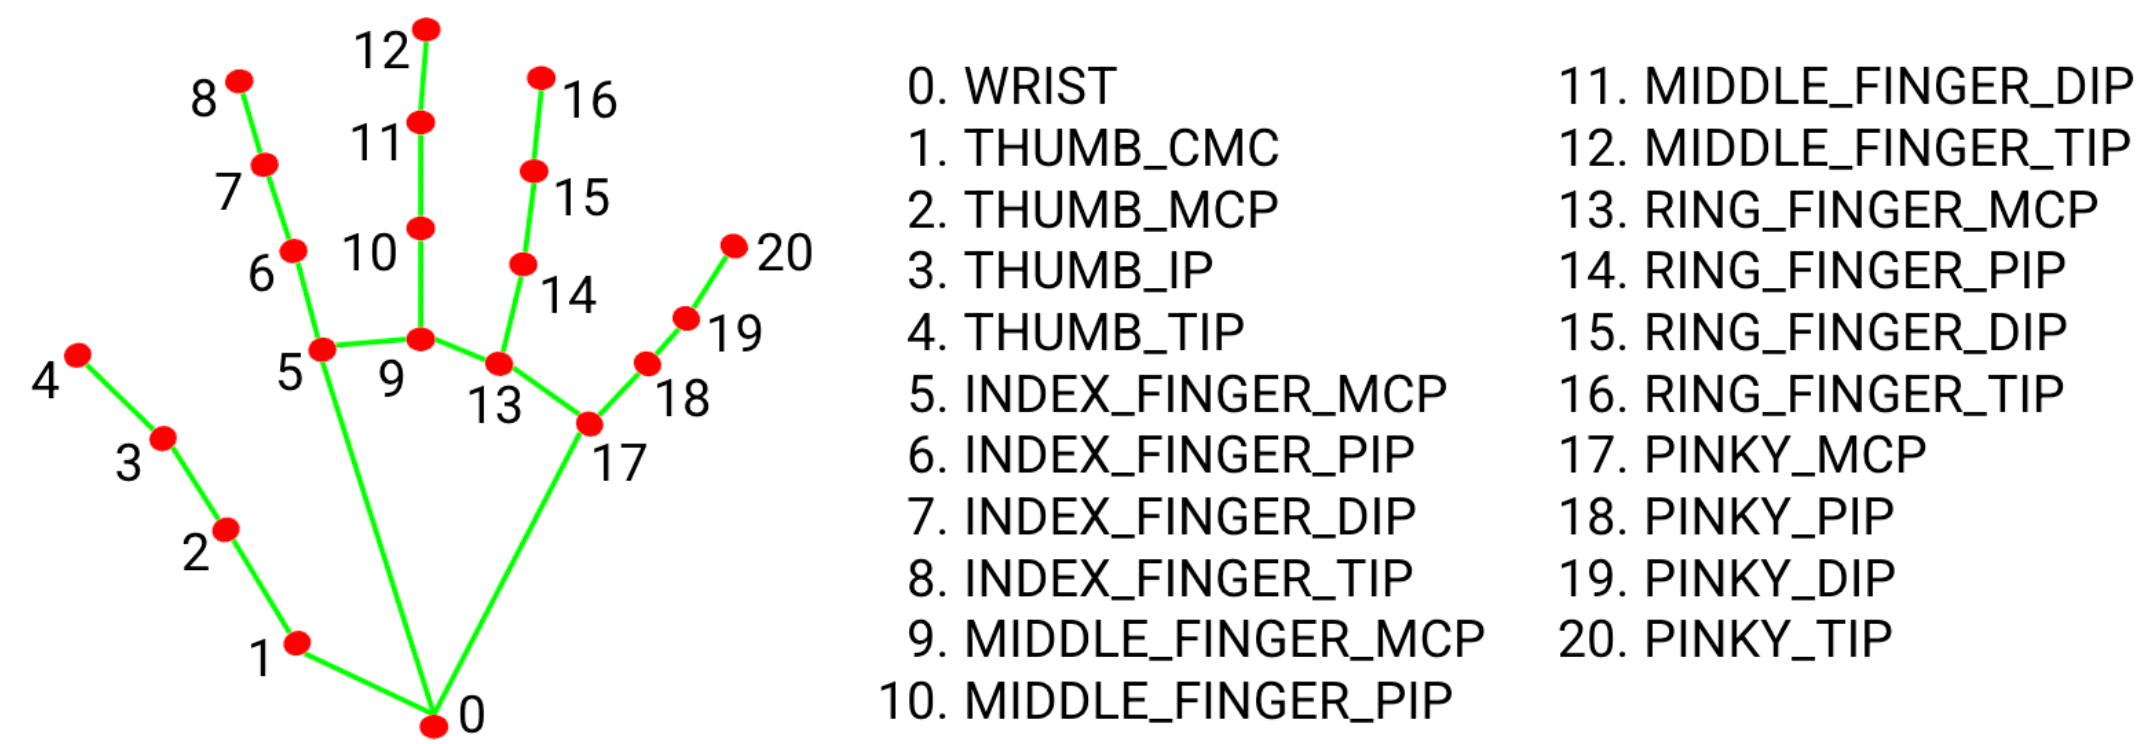

In [ ]:
import matplotlib.pyplot as plt

landmark = "x8"  # can change to other landmarks to inspect
plt.figure(figsize=(12,6))
combined_df.boxplot(column=landmark, by="gesture", rot=45, grid=False)
plt.title(f"Distribution of {landmark} by gesture")
plt.suptitle("")
plt.xlabel("Gesture")
plt.ylabel(f"{landmark} (normalized)")
plt.tight_layout()
plt.show()


# Mean hand shape per gesture (skeleton average) — numeric + visual

Compute mean 21×3 vector per gesture and visualize as a skeleton overlay. Average skeletons reveal per-gesture canonical pose; useful for sanity checks and for presenting prototypes.

In [ ]:
# Cell: mean landmark per gesture and plotting helper
import numpy as np

# Mediapipe hand connections (pairs of landmark indices)
CONNECTIONS = [
    (0,1),(1,2),(2,3),(3,4),      # thumb
    (0,5),(5,6),(6,7),(7,8),      # index
    (0,9),(9,10),(10,11),(11,12), # middle
    (0,13),(13,14),(14,15),(15,16),# ring
    (0,17),(17,18),(18,19),(19,20) # pinky
]

def mean_shape_for_gesture(g):
    sub = combined_df[combined_df["gesture"]==g]
    arr = sub[landmark_cols].values
    mean_vec = np.nanmean(arr, axis=0)  # shape (63,)
    coords = mean_vec.reshape(21,3)
    return coords

gestures = combined_df["gesture"].unique() 


for i in range(len(gestures)):

    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(111, projection='3d')

    coords = mean_shape_for_gesture(gestures[i])
    x, y, z = coords[:,0], coords[:,1], coords[:,2]

    ax.scatter(x, y, z, s=40)

    for (a,b) in CONNECTIONS:
        ax.plot([x[a],x[b]], [y[a],y[b]], [z[a],z[b]], linewidth=2)

    ax.set_title(gestures[i])
    ax.view_init(elev=45, azim=45) 
    plt.show()

